Temperature Prediction
Using LSTM model with TFLite
Predicting temperature, 1 hour in the future

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## Load the dataset

In [2]:
df = pd.read_csv('Lawrence_Data.csv')
df.shape

(961, 3)

In [3]:
df.head()

,datetime,temp,humidity
0,2024-11-01T00:00:00,2.3,99.38
1,2024-11-01T01:00:00,3.0,94.92
2,2024-11-01T02:00:00,1.3,99.46
3,2024-11-01T03:00:00,1.3,99.39
4,2024-11-01T04:00:00,0.2,99.38


In [4]:
'''# Splitting the dataset based on row ranges
train_data = df.iloc[1:673]   # Rows 2 to 674 (index starts at 0)
val_data = df.iloc[674:793]  # Rows 675 to 770
test_data = df.iloc[793:962]  # Rows 771 to 962

# Save the splits to verify
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("Dataset has been split and saved:")
print(f"Training set: {train_data.shape[0]} rows")
print(f"Validation set: {val_data.shape[0]} rows")
print(f"Testing set: {test_data.shape[0]} rows")'''

'# Splitting the dataset based on row ranges\ntrain_data = df.iloc[1:673]   # Rows 2 to 674 (index starts at 0)\nval_data = df.iloc[674:793]  # Rows 675 to 770\ntest_data = df.iloc[793:962]  # Rows 771 to 962\n\n# Save the splits to verify\ntrain_data.to_csv("train_data.csv", index=False)\nval_data.to_csv("val_data.csv", index=False)\ntest_data.to_csv("test_data.csv", index=False)\n\nprint("Dataset has been split and saved:")\nprint(f"Training set: {train_data.shape[0]} rows")\nprint(f"Validation set: {val_data.shape[0]} rows")\nprint(f"Testing set: {test_data.shape[0]} rows")'

In [5]:
# Sort the DataFrame by date_time
df.sort_values(by='datetime', inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df

,datetime,temp,humidity
0,2024-11-01T00:00:00,2.3,99.38
1,2024-11-01T01:00:00,3.0,94.92
2,2024-11-01T02:00:00,1.3,99.46
3,2024-11-01T03:00:00,1.3,99.39
4,2024-11-01T04:00:00,0.2,99.38
...,...,...,...
956,2024-12-10T19:00:00,1.3,57.82
957,2024-12-10T20:00:00,0.3,62.62
958,2024-12-10T21:00:00,-0.6,66.85
959,2024-12-10T22:00:00,-1.1,69.34


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  961 non-null    object 
 1   temp      961 non-null    float64
 2   humidity  961 non-null    float64
dtypes: float64(2), object(1)
memory usage: 22.6+ KB


In [8]:

df.isna().sum()

,0
datetime,0
temp,0
humidity,0


In [9]:
df[df.isna().any(axis=1)]

,datetime,temp,humidity


In [10]:
# Selecting relevant columns
numeric_cols = ['temp', 'humidity']
data_selected = df[numeric_cols]
data_selected.shape

(961, 2)

In [11]:
data_selected = data_selected.fillna(data_selected.mean())

In [12]:
data_selected.isna().sum()

,0
temp,0
humidity,0


In [13]:
data_selected.head()

,temp,humidity
0,2.3,99.38
1,3.0,94.92
2,1.3,99.46
3,1.3,99.39
4,0.2,99.38


In [14]:
# For display only
five_weeks_data = data_selected[:840]
five_weeks_data

,temp,humidity
0,2.3,99.38
1,3.0,94.92
2,1.3,99.46
3,1.3,99.39
4,0.2,99.38
...,...,...
835,-3.3,44.10
836,-3.8,45.78
837,-5.5,54.20
838,-6.1,56.73


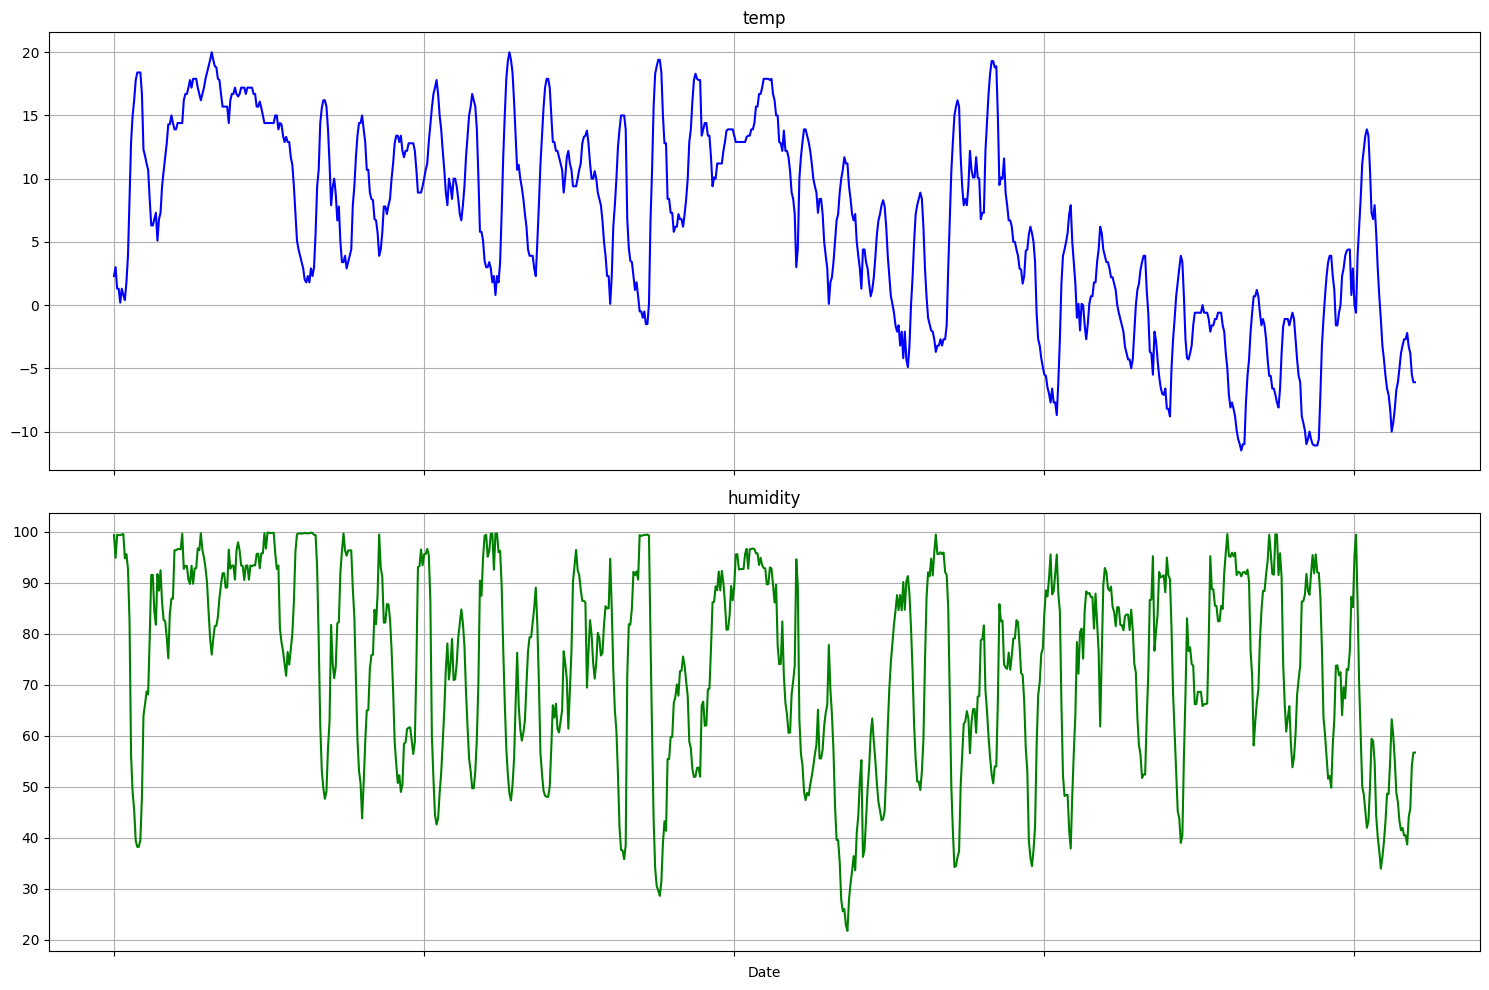

In [15]:
# Define colors for each feature for visibility
colors = ['blue', 'green']
n_features = 2
plt.figure(figsize=(15, 10))

# Plot each feature with specified color and share the x-axis
for i, (feature, color) in enumerate(zip(five_weeks_data.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)  # Share the x-axis
    five_weeks_data[feature].plot(ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.grid(True)

    # Only show the x-axis label on the last subplot
    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

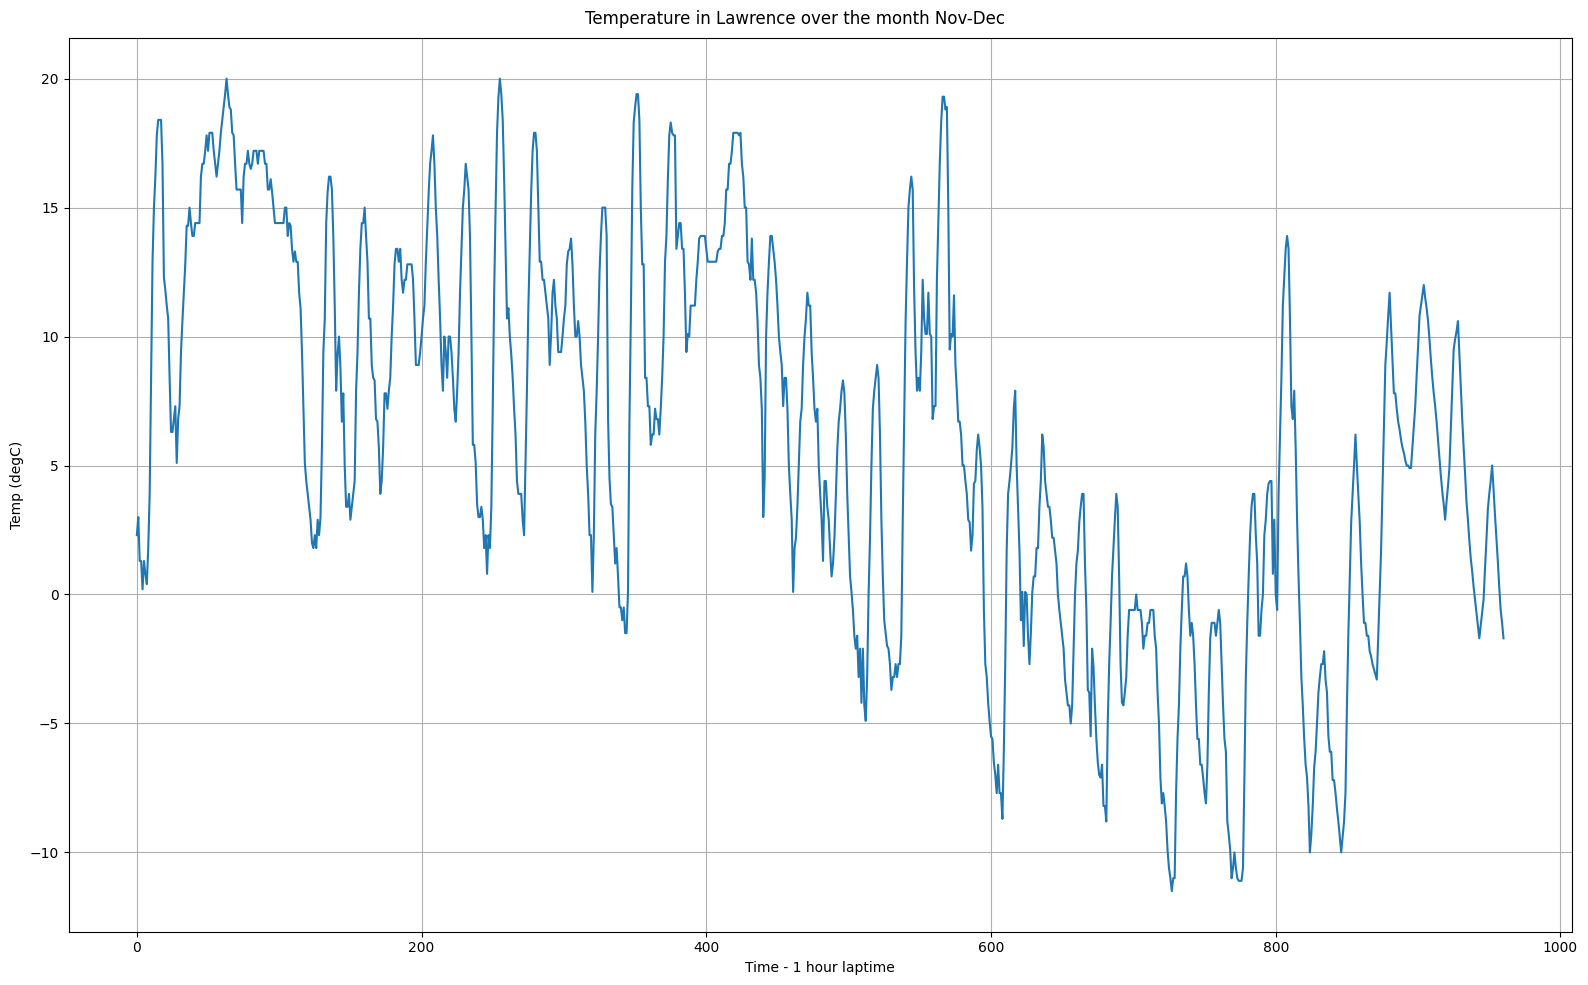

In [16]:
fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.set_xlabel('Time - 1 hour laptime')
ax1.set_ylabel('Temp (degC)')
ax1.plot(data_selected['temp'], linestyle='-')
ax1.tick_params(axis='y')

# Optional: Add a title and adjust layout
plt.suptitle('Temperature in Lawrence over the month Nov-Dec')
plt.grid()
fig.tight_layout()  # adjust subplot parameters to give specified padding

plt.show()

## Splitting the dataset into training, validation, and testing sets

In [17]:
SPLIT = 0.8

In [18]:
train_size = int(len(data_selected) * SPLIT)
val_size = int(len(data_selected) * (1-SPLIT)//2)
test_size = len(data_selected) - train_size - val_size

train_data = data_selected[:train_size]
val_data = data_selected[train_size:train_size + val_size]
test_data = data_selected[-test_size:]

train_data.shape, val_data.shape, test_data.shape

((768, 2), (96, 2), (97, 2))

In [19]:
train_data, val_data, test_data

(     temp  humidity
 0     2.3     99.38
 1     3.0     94.92
 2     1.3     99.46
 3     1.3     99.39
 4     0.2     99.38
 ..    ...       ...
 763  -4.3     68.08
 764  -5.6     71.09
 765  -6.1     73.83
 766  -8.8     86.36
 767  -9.3     86.41
 
 [768 rows x 2 columns],
      temp  humidity
 768  -9.9     87.64
 769 -11.0     91.77
 770 -10.6     88.42
 771 -10.0     87.68
 772 -10.6     91.86
 ..    ...       ...
 859   2.8     47.75
 860   1.2     56.06
 861   0.0     61.13
 862  -1.1     68.81
 863  -1.1     68.81
 
 [96 rows x 2 columns],
      temp  humidity
 864  -1.6     74.72
 865  -1.6     74.72
 866  -2.2     78.10
 867  -2.4     81.09
 868  -2.7     84.17
 ..    ...       ...
 956   1.3     57.82
 957   0.3     62.62
 958  -0.6     66.85
 959  -1.1     69.34
 960  -1.7     71.91
 
 [97 rows x 2 columns])

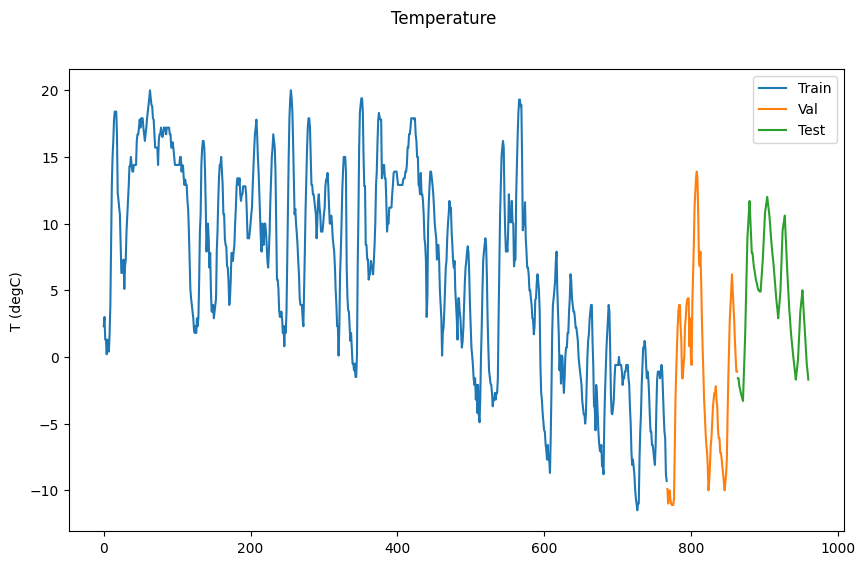

In [20]:
plt.figure(figsize=(10, 6))
train_data['temp'].plot(legend=True)
val_data['temp'].plot(legend=True)
test_data['temp'].plot(legend=True)
plt.legend(['Train', 'Val', 'Test']);
plt.suptitle('Temperature')
plt.ylabel('T (degC)');

## Normalize the data

In [21]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_features_normalized = scaler.fit_transform(train_data)
val_features_normalized = scaler.transform(val_data)
test_features_normalized = scaler.transform(test_data)

### Save the scaler parameters to a Text file

In [23]:
# Save the scaler parameters to a text file
with open('scaler_params.txt', 'w') as file:
    file.write('scale:' + ','.join(map(str, scaler.scale_)) + '\n')
    file.write('min:' + ','.join(map(str, scaler.min_)) + '\n')
    file.write('data_min:' + ','.join(map(str, scaler.data_min_)) + '\n')
    file.write('data_max:' + ','.join(map(str, scaler.data_max_)) + '\n')
    file.write('data_range:' + ','.join(map(str, scaler.data_range_)) + '\n')

In [24]:
print(f'Train: {train_features_normalized.min()}, {train_features_normalized.max()}')
print(f'Test:  {test_features_normalized.min()}, {test_features_normalized.max()}')
print(f'Val:   {val_features_normalized.min()}, {val_features_normalized.max()}')

Train: 0.0, 1.0
Test:  0.2603174603174603, 0.9544290834613414
Val:   0.012698412698412709, 0.9942396313364055


## Create Features
- Prediction will be Temperature

In [25]:
def create_sequences(input_data, n_steps, fut_hours, out_feat_index):
    X, y = [], []
    for i in range(len(input_data) - n_steps - fut_hours):
        # Define the end of the input sequence
        end_ix = i + n_steps
        # Define the end of the output sequence
        out_end_ix = end_ix + fut_hours
        # Ensure we have enough data for this instance
        if out_end_ix > len(input_data):
            break
        # Retrieve input and output
        seq_x, seq_y = input_data[i:end_ix, :], input_data[out_end_ix - 1, out_feat_index]  # i.e. 0 is the index for 'tempC'
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [26]:
# Creating sequences (using 168 timesteps, which is 1 weekm 7x24)
output_feature = 'temp'
out_feat_index = numeric_cols.index(output_feature)
fut_hours = 1
n_steps = 24
n_inputs = len(data_selected.columns)

In [27]:
X_train, y_train = create_sequences(train_features_normalized, n_steps, fut_hours, out_feat_index)
X_val, y_val = create_sequences(val_features_normalized, n_steps, fut_hours, out_feat_index)
X_test, y_test = create_sequences(test_features_normalized, n_steps, fut_hours, out_feat_index)


In [28]:

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(743, 24, 2) (743,)
(72, 24, 2) (72,)
(71, 24, 2) (71,)


## Design Model

In [29]:
# Building the LSTM model
model = Sequential([
    LSTM(128,
         input_shape=(n_steps, X_train.shape[2]), unroll=True),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [30]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True)

In [31]:
# Define your batch size and EPOCHS
BATCH = 32
EPOCHS = 20

In [32]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - loss: 0.1123 - val_loss: 0.0295
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0234 - val_loss: 0.0216
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0109
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0075
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - va

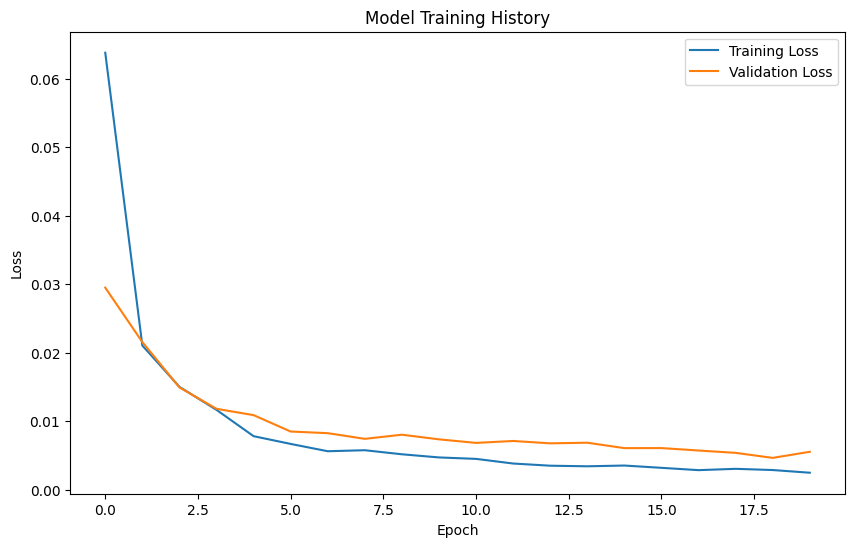

In [33]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [34]:
from math import sqrt
err = model.evaluate(X_test, y_test)
print(f'  RMSE test:\t {sqrt(err):.3f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 932ms/step - loss: 6.0632e-04
  RMSE test:	 0.025


In [35]:
prediccion = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 952ms/step


In [36]:
prediccion

array([[0.54341006],
       [0.5377664 ],
       [0.53306705],
       [0.5283916 ],
       [0.5219673 ],
       [0.5172343 ],
       [0.5203933 ],
       [0.5268518 ],
       [0.5376424 ],
       [0.55889165],
       [0.58744335],
       [0.6212509 ],
       [0.6699445 ],
       [0.7168958 ],
       [0.7577276 ],
       [0.77511007],
       [0.7756183 ],
       [0.76905364],
       [0.7479619 ],
       [0.72407115],
       [0.7006559 ],
       [0.6753846 ],
       [0.64762145],
       [0.62260294],
       [0.60612744],
       [0.59425265],
       [0.58269274],
       [0.5699487 ],
       [0.5550927 ],
       [0.53842837],
       [0.52452636],
       [0.5161735 ],
       [0.5064857 ],
       [0.5150972 ],
       [0.53513235],
       [0.5625233 ],
       [0.6141972 ],
       [0.66916674],
       [0.7108941 ],
       [0.7183467 ],
       [0.7040714 ],
       [0.6865021 ],
       [0.64993113],
       [0.6085182 ],
       [0.56823623],
       [0.5324657 ],
       [0.5018079 ],
       [0.472

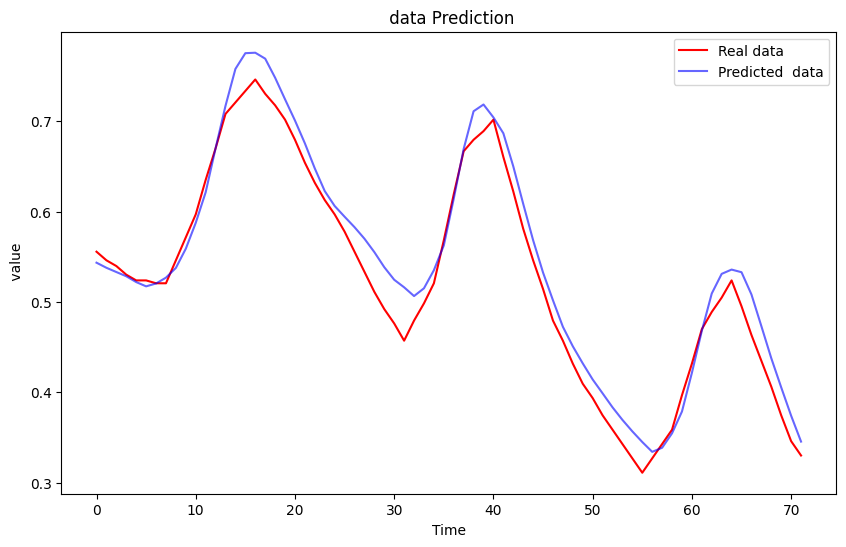

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(prediccion, color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()

In [38]:
'''plt.figure(figsize=(10, 6))
plt.plot(y_test[12000:], color = 'red', label = 'Real data')
plt.plot(prediccion[12000:], color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()'''

"plt.figure(figsize=(10, 6))\nplt.plot(y_test[12000:], color = 'red', label = 'Real data')\nplt.plot(prediccion[12000:], color = 'blue', label = 'Predicted  data', alpha = 0.6)\nplt.title(' data Prediction')\nplt.xlabel('Time')\nplt.ylabel(' value')\nplt.legend()\nplt.show()"

## Create TFLite LSTM Model - Float32

In [39]:
import os
run_model = tf.function(lambda x: model(x))

BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = n_inputs
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
# Create a valid directory for the saved model
MODEL_DIR = '/content/keras_lstm_saved_model'
os.makedirs(MODEL_DIR, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model in the correct format
model.export("/content/keras_lstm_saved_model/keras_model.keras")

converter = tf.lite.TFLiteConverter.from_saved_model("/content/keras_lstm_saved_model/keras_model.keras")
tflite_model = converter.convert()

# Save the converted model to file
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/content/keras_lstm_saved_model/keras_model.keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135818455646448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135818438618880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135818438616592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135818455972176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135818455966016: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [40]:
'''import os
import tensorflow as tf

# Ensure your model is a Keras model (if not already)
# Replace this with your own model initialization
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(n_steps, n_inputs), recurrent_initializer='glorot_uniform'),
    # Add other layers if needed
    tf.keras.layers.Dense(1)
])

# Wrap the model in a tf.function
run_model = tf.function(lambda x: model(x))

BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = n_inputs

# Get the concrete function with the appropriate input signature
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# Model directory
MODEL_DIR = '/content/keras_lstm_saved_model'
os.makedirs(MODEL_DIR, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model in the correct format
model.export("/content/keras_lstm_saved_model/keras_model.keras")

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("/content/keras_lstm_saved_model/keras_model.keras")
converter.allow_custom_ops = True  # Allow custom ops if necessary
tflite_model = converter.convert()

# Save the converted model to a file
tflite_model_file = '/content/converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to: {tflite_model_file}")'''


'import os\nimport tensorflow as tf\n\n# Ensure your model is a Keras model (if not already)\n# Replace this with your own model initialization\nmodel = tf.keras.Sequential([\n    tf.keras.layers.LSTM(128, input_shape=(n_steps, n_inputs), recurrent_initializer=\'glorot_uniform\'),\n    # Add other layers if needed\n    tf.keras.layers.Dense(1)\n])\n\n# Wrap the model in a tf.function\nrun_model = tf.function(lambda x: model(x))\n\nBATCH_SIZE = 1\nSTEPS = n_steps\nINPUT_SIZE = n_inputs\n\n# Get the concrete function with the appropriate input signature\nconcrete_func = run_model.get_concrete_function(\n    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))\n\n# Model directory\nMODEL_DIR = \'/content/keras_lstm_saved_model\'\nos.makedirs(MODEL_DIR, exist_ok=True)  # Create the directory if it doesn\'t exist\n\n# Save the model in the correct format\nmodel.export("/content/keras_lstm_saved_model/keras_model.keras")\n\n# Convert the model to TensorFlow Lite\nconverter 

In [41]:
# Initialize the TFLite interpreter
interp = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
interp.allocate_tensors()

# Get input/output layer information
i_details = interp.get_input_details()[0]
o_details = interp.get_output_details()[0]

In [42]:
i_details

{'name': 'serving_default_keras_tensor:0',
 'index': 0,
 'shape': array([ 1, 24,  2], dtype=int32),
 'shape_signature': array([-1, 24,  2], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [43]:
o_details

{'name': 'StatefulPartitionedCall_1:0',
 'index': 449,
 'shape': array([1, 1], dtype=int32),
 'shape_signature': array([-1,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

## Deploy LSTM Float32 Model (Unidirecional operator)

### Install the Python SDK library:

In [44]:
!python -m pip install edgeimpulse
import edgeimpulse as ei

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.3
    Uninstalling pydantic-2.10.3:
      Successful

In [45]:
ei.API_KEY = "ei_662a082ceb40d3aa926845b1cf119f916f8e73191e303d3b2de4620688a52551" # Change to your key

In [46]:
# Estimate the RAM, ROM, and inference time for our model on the target hardware family
try:
    profile = ei.model.profile(model=tflite_model,
                               device='espressif-esp32')
    print(profile.summary())
except Exception as e:
    print(f"Could not profile: {e}")

Target results for float32:
{
    "device": "espressif-esp32",
    "tfliteFileSizeBytes": 336328,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 124884,
            "rom": 391008,
            "arenaSize": 124268
        },
        "eon": {
            "ram": 80928,
            "rom": 323456,
            "arenaSize": 58656
        }
    },
    "timePerInferenceMs": 584
}


Performance on device types:
{
    "variant": "float32",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 6637,
        "memory": {
            "tflite": {
                "ram": 123003,
                "rom": 382400
            },
            "eon": {
                "ram": 79360,
                "rom": 319312
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInf

In [47]:
download_dir = "C:\\Users\\dimpl\\Downloads"
deploy_filename = "lstm_float32_model_real.zip"

In [48]:
# Create an Arduino library with trained model
deploy_bytes = None
try:
    deploy_bytes = ei.model.deploy(tflite_model,
                                   model_output_type=ei.model.output_type.Regression(),
                                   deploy_target='arduino')
except Exception as e:
    print(f"Could not deploy: {e}")

# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

## Generate test datapoint for inference

In [49]:
y_test[0]

0.5555555555555556

In [50]:
X_test[0].shape

(24, 2)

In [51]:
reshaped_test = X_test[0].reshape(-1)
reshaped_test.shape

(48,)

In [52]:
import sys
np.set_printoptions(threshold=sys.maxsize)
reshaped_test

array([0.31428571, 0.67780338, 0.31428571, 0.67780338, 0.2952381 ,
       0.72107015, 0.28888889, 0.7593446 , 0.27936508, 0.79877112,
       0.27301587, 0.8484383 , 0.26666667, 0.90028162, 0.26031746,
       0.95442908, 0.31428571, 0.86699949, 0.36507937, 0.80299539,
       0.41904762, 0.72900666, 0.4952381 , 0.64260113, 0.57142857,
       0.56592422, 0.64761905, 0.49743984, 0.67619048, 0.47299027,
       0.70793651, 0.43958013, 0.73650794, 0.41756272, 0.6952381 ,
       0.49116743, 0.65396825, 0.57322069, 0.61269841, 0.66487455,
       0.61269841, 0.65168971, 0.59365079, 0.71134153, 0.57777778,
       0.76766513, 0.56825397, 0.78200205])

### Rescaling inference result to real temperaure

To load these parameters back into a MinMaxScaler instance:

In [53]:
# Load the scaler parameters from the text file
loaded_scaler_params = {}
with open('scaler_params.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        loaded_scaler_params[key] = np.array([float(i) for i in value.split(',')])

# Create a new scaler instance and set its parameters
inference_scaler = MinMaxScaler()
inference_scaler.scale_ = loaded_scaler_params['scale']
inference_scaler.min_ = loaded_scaler_params['min']
inference_scaler.data_min_ = loaded_scaler_params['data_min']
inference_scaler.data_max_ = loaded_scaler_params['data_max']
inference_scaler.data_range_ = loaded_scaler_params['data_range']

In [54]:
inference_scaler.data_min_.shape

(2,)

In [55]:
data_min = inference_scaler.data_min_[0]
data_min

-11.5

In [56]:
data_max = inference_scaler.data_max_[0]
data_max

20.0

In [58]:
value = 0.5555555555555556
temp = value * (data_max - data_min) + data_min
temp

6.0

In [ ]:
value1 = 0.5555555555555556
temp1 = value1 * (data_max - data_min) + data_min
temp1